In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import firwin, lfilter, butter, filtfilt, iirnotch
import matplotlib.pyplot as plt

import seaborn as sns
import re
from scipy.signal import firwin, lfilter, butter, filtfilt, iirnotch

# Johanni

In [ ]:
L3_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/JohaN2.txt')
L5_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/JohaN2.txt')

[513.5 513.  514.  ... 509.  516.  519. ]


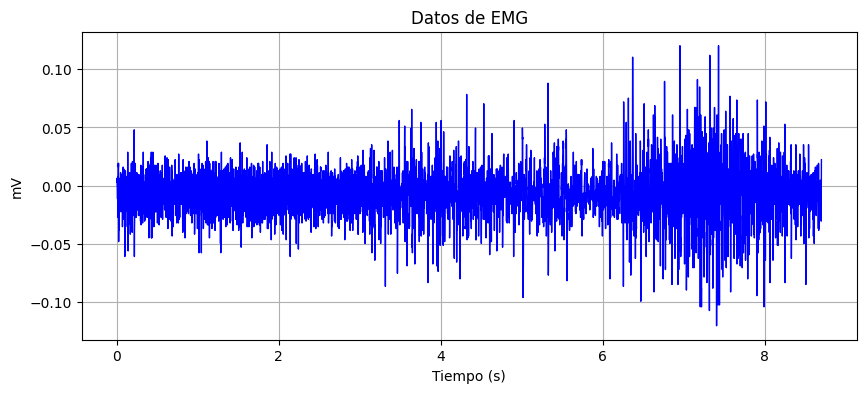

In [ ]:
VCC = 3.3
n = 10

Fs = 1000
#cargamos los datos desde el archivo txt

datos1 = L3_data[:, 16] #el 5 y 16 contienen la información
datos2 = L5_data[:, 5]
datos = (datos1 + datos2)/2
print(datos)
datos = 1000*((((datos/(2**n)) - 0.5) * VCC)/1009)


# Función para aplicar el umbral
def apply_threshold(arr, upper_threshold=0.12, lower_threshold=-0.12):
    arr = np.where(arr > upper_threshold, upper_threshold, arr)
    arr = np.where(arr < lower_threshold, lower_threshold, arr)
    return arr

datos = apply_threshold(datos)



frec_muestreo = Fs #por el teorema de Nyquist
tiempo = np.arange(len(datos)) / frec_muestreo
plt.figure(figsize=(10, 4))  # Ajusta el tamaño del gráfico según tus necesidades
plt.plot(tiempo, datos, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('mV')
plt.title('Datos de EMG')
plt.grid(True)
plt.show()

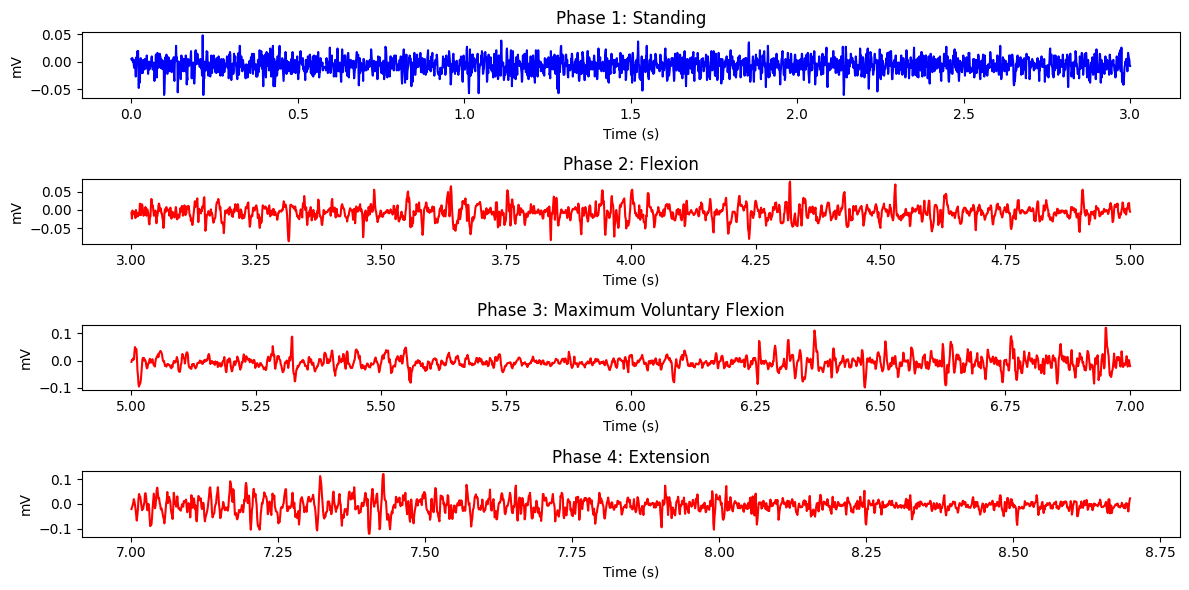

In [ ]:
segment_1 = (tiempo >= 0) & (tiempo <= 3) #standing
segment_2 = (tiempo >= 3) & (tiempo <= 5) #flexión
segment_3 = (tiempo >= 5) & (tiempo <= 7) #Máxima flexión
segment_4 = (tiempo >= 7) & (tiempo <= 9) #extensión

time_segment_1 = tiempo[segment_1]
signal_segment_1 = datos[segment_1]

time_segment_2 = tiempo[segment_2]
signal_segment_2 = datos[segment_2]

time_segment_3 = tiempo[segment_3]
signal_segment_3 = datos[segment_3]

time_segment_4 = tiempo[segment_4]
signal_segment_4 = datos[segment_4]

# Plotting the segmented signals
plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.plot(time_segment_1, signal_segment_1, color='blue')
plt.title("Phase 1: Standing")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 2)
plt.plot(time_segment_2, signal_segment_2, color='red')
plt.title("Phase 2: Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 3)
plt.plot(time_segment_3, signal_segment_3, color='red')
plt.title("Phase 3: Maximum Voluntary Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 4)
plt.plot(time_segment_4, signal_segment_4, color='red')
plt.title("Phase 4: Extension")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.tight_layout()
plt.show()

In [ ]:
raw_average_segm_phase1 = np.mean(signal_segment_1)
print(f"Raw Average SEMG Phase 1: {raw_average_segm_phase1} mV")

raw_maximum_segm_phase2 = np.max(signal_segment_2)
print(f"Raw Maximum SEMG Phase 2: {raw_maximum_segm_phase2} mV")

raw_average_segm_phase3 = np.mean(signal_segment_3)
print(f"Raw Average SEMG Phase 3: {raw_average_segm_phase3} mV")

raw_maximum_segm_phase4 = np.max(signal_segment_4)
print(f"Raw Maximum SEMG Phase 4: {raw_maximum_segm_phase4} mV")

Raw Average SEMG Phase 1: -0.006902934713040813 mV
Raw Maximum SEMG Phase 2: 0.0782508207383548 mV
Raw Average SEMG Phase 3: -0.007172903343298618 mV
Raw Maximum SEMG Phase 4: 0.12 mV


FRR FLEX/MVF: 1.586061281448174
FRR EXT/MVF: 2.613938601874577
Max valor de flexión: 2.348715644752731
Mean valor de max_flexión: 1.4808479799772967
Max valor de extensión: 3.8708456983706463


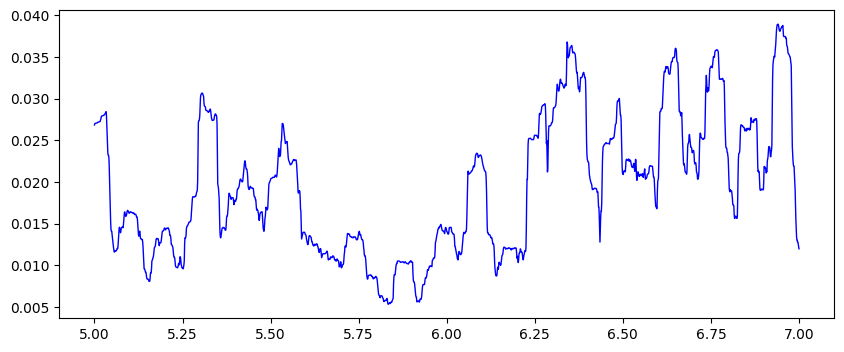

In [ ]:
# Frecuencia de muestreo
sampling_rate = 1000

# Filtrado de paso banda
def bandpass_filter(signal, lowcut, highcut, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Filtro Notch
def notch_filter(signal, notch_freq, sampling_rate, quality_factor=30):
    nyquist = 0.5 * sampling_rate
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Aplicar filtros
bandpass_reposo_emg = bandpass_filter(signal_segment_1, 20, 430, sampling_rate)
bandpass_flexion_emg = bandpass_filter(signal_segment_2, 20, 430, sampling_rate)
bandpass_max_flexion_emg = bandpass_filter(signal_segment_3, 20, 430, sampling_rate)
bandpass_extension_emg = bandpass_filter(signal_segment_4, 20, 430, sampling_rate)

notch_reposo_emg = notch_filter(bandpass_reposo_emg, 60, sampling_rate)
notch_flexion_emg = notch_filter(bandpass_flexion_emg, 60, sampling_rate)
notch_max_flexion_emg = notch_filter(bandpass_max_flexion_emg, 60, sampling_rate)
notch_extension_emg = notch_filter(bandpass_extension_emg, 60, sampling_rate)

# Rectificación
rectified_reposo_emg = np.abs(notch_reposo_emg)
rectified_flexion_emg = np.abs(notch_flexion_emg)
rectified_max_flexion_emg = np.abs(notch_max_flexion_emg)
rectified_extension_emg = np.abs(notch_extension_emg)

# Suavizado con RMS
def rms_filter(signal, window_size):
    rms_signal = np.sqrt(np.convolve(signal**2, np.ones(window_size)/window_size, mode='same'))
    return rms_signal

window_size = 55 #int(0.1 * sampling_rate)  # 100 ms window
smoothed_reposo_emg = rms_filter(rectified_reposo_emg, window_size)
smoothed_flexion_emg = rms_filter(rectified_flexion_emg, window_size)
smoothed_max_flexion_emg = rms_filter(rectified_max_flexion_emg, window_size)
smoothed_extension_emg = rms_filter(rectified_extension_emg, window_size)

# Normalización
def normalize(signal, stand):
    return (signal) / (np.mean(stand))

#normalized_reposo_emg = normalize(smoothed_reposo_emg)
normalized_flexion_emg = normalize(smoothed_flexion_emg, smoothed_reposo_emg)
normalized_max_flexion_emg = normalize(smoothed_max_flexion_emg, smoothed_reposo_emg)
normalized_extension_emg = normalize(smoothed_extension_emg, smoothed_reposo_emg)



# Placeholder para calcular FRR
def calculate_frr(max_flex_signal, mean_mvf_signal, max_ext_signal):
    frr_flex_mvf = max_flex_signal / mean_mvf_signal
    frr_ext_mvf = max_ext_signal / mean_mvf_signal
    return frr_flex_mvf, frr_ext_mvf

max_flexion_value = np.max(normalized_flexion_emg)
mean_mvf_value = np.mean(normalized_max_flexion_emg)
max_extension_value = np.max(normalized_extension_emg)

# Calcular FRR FLEX/MVF y FRR EXT/MVF
frr_flex_mvf, frr_ext_mvf = calculate_frr(max_flexion_value, mean_mvf_value, max_extension_value)

# Imprimir FRR
print(f"FRR FLEX/MVF: {frr_flex_mvf}")
print(f"FRR EXT/MVF: {frr_ext_mvf}")

print(f"Max valor de flexión: {max_flexion_value}")
print(f"Mean valor de max_flexión: {mean_mvf_value}")
print(f"Max valor de extensión: {max_extension_value}")


plt.figure(figsize=(10, 4))
plt.plot(time_segment_3, smoothed_max_flexion_emg, lw=1, color='blue')

# Romina

In [ ]:
L3_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/Romina1.txt')
L5_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/Romina1.txt')

[507.5 508.5 506.5 ... 509.  509.  508.5]


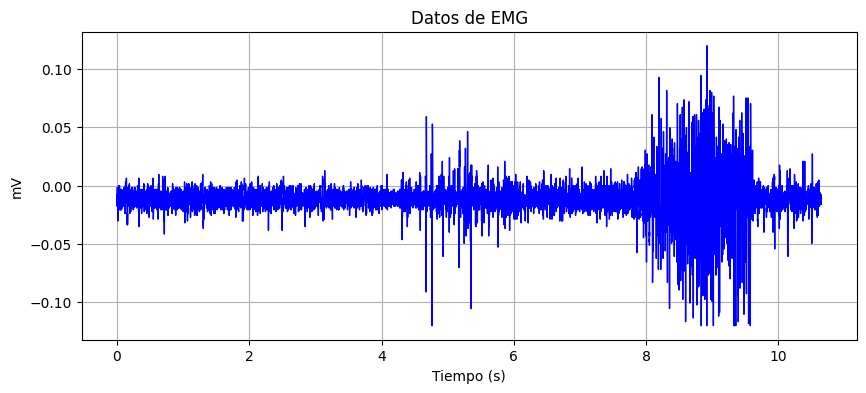

In [ ]:
VCC = 3.3
n = 10

Fs = 1000
#cargamos los datos desde el archivo txt

datos1 = L3_data[:, 16] #el 5 y 16 contienen la información
datos2 = L5_data[:, 5]
datos = (datos1+datos2)/2
print(datos)
datos = 1000*((((datos/(2**n)) - 0.5) * VCC)/1009)


# Función para aplicar el umbral
def apply_threshold(arr, upper_threshold=0.12, lower_threshold=-0.12):
    arr = np.where(arr > upper_threshold, upper_threshold, arr)
    arr = np.where(arr < lower_threshold, lower_threshold, arr)
    return arr

datos = apply_threshold(datos)

frec_muestreo = Fs #por el teorema de Nyquist
tiempo = np.arange(len(datos)) / frec_muestreo
plt.figure(figsize=(10, 4))  # Ajusta el tamaño del gráfico según tus necesidades
plt.plot(tiempo, datos, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('mV')
plt.title('Datos de EMG')
plt.grid(True)
plt.show()

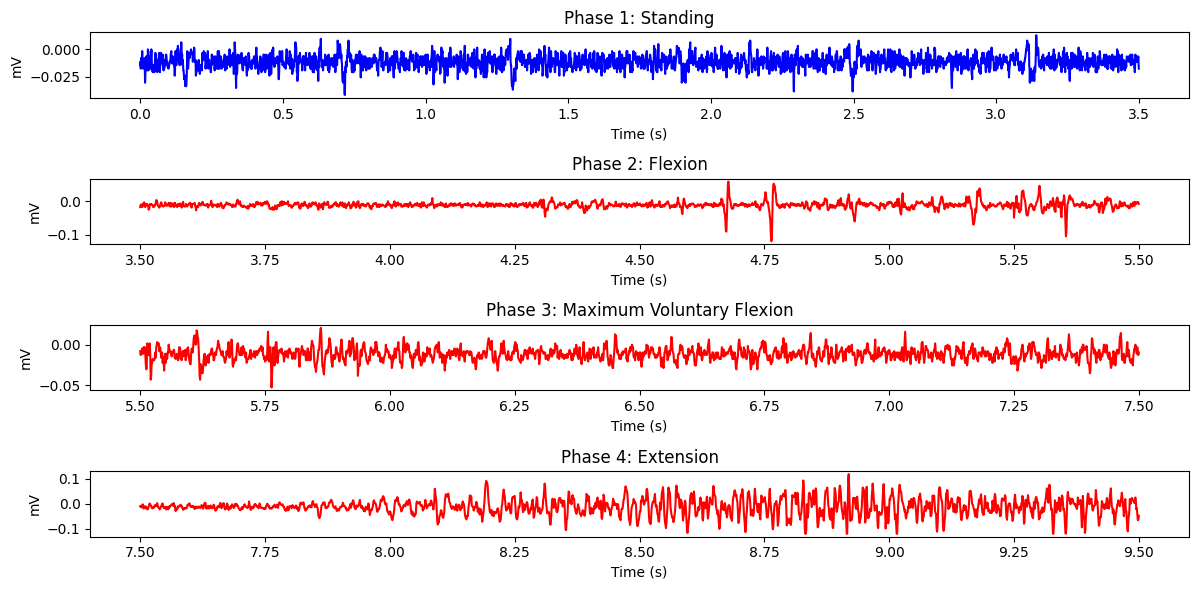

In [ ]:
segment_1 = (tiempo >= 0) & (tiempo <= 3.5) #standing
segment_2 = (tiempo >= 3.5) & (tiempo <= 5.5) #flexión
segment_3 = (tiempo >= 5.5) & (tiempo <= 7.5) #Máxima flexión
segment_4 = (tiempo >= 7.5) & (tiempo <= 9.5) #extensión

time_segment_1 = tiempo[segment_1]
signal_segment_1 = datos[segment_1]

time_segment_2 = tiempo[segment_2]
signal_segment_2 = datos[segment_2]

time_segment_3 = tiempo[segment_3]
signal_segment_3 = datos[segment_3]

time_segment_4 = tiempo[segment_4]
signal_segment_4 = datos[segment_4]

# Plotting the segmented signals
plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.plot(time_segment_1, signal_segment_1, color='blue')
plt.title("Phase 1: Standing")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 2)
plt.plot(time_segment_2, signal_segment_2, color='red')
plt.title("Phase 2: Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 3)
plt.plot(time_segment_3, signal_segment_3, color='red')
plt.title("Phase 3: Maximum Voluntary Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 4)
plt.plot(time_segment_4, signal_segment_4, color='red')
plt.title("Phase 4: Extension")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.tight_layout()
plt.show()


In [ ]:
raw_average_segm_phase1 = np.mean(signal_segment_1)
print(f"Raw Average SEMG Phase 1: {raw_average_segm_phase1} mV")

raw_maximum_segm_phase2 = np.max(signal_segment_2)
print(f"Raw Maximum SEMG Phase 2: {raw_maximum_segm_phase2} mV")

raw_average_segm_phase3 = np.mean(signal_segment_3)
print(f"Raw Average SEMG Phase 3: {raw_average_segm_phase3} mV")

raw_maximum_segm_phase4 = np.max(signal_segment_4)
print(f"Raw Maximum SEMG Phase 4: {raw_maximum_segm_phase4} mV")

Raw Average SEMG Phase 1: -0.011386233596644762 mV
Raw Maximum SEMG Phase 2: 0.05908735443508424 mV
Raw Average SEMG Phase 3: -0.011405343034317826 mV
Raw Maximum SEMG Phase 4: 0.11977166439544104 mV


FRR FLEX/MVF: 3.927574341760175
FRR EXT/MVF: 7.340268426295096
Raw Average SEMG Phase 1 : 0.005536319274827537
Max valor de flexión: 5.084478070848252
Mean valor de max_flexión: 1.29455934590142
Max valor de extensión: 9.502413092685424


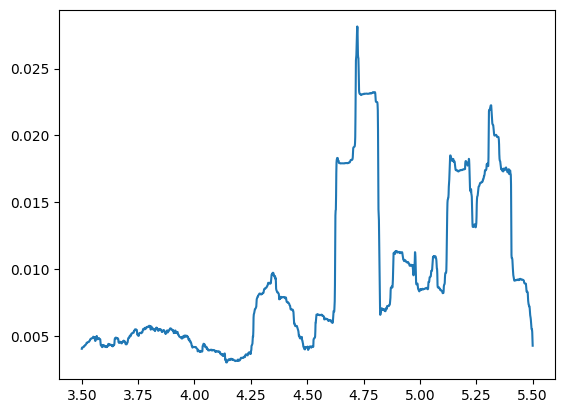

In [ ]:
# Frecuencia de muestreo
sampling_rate = 1000

# Filtrado de paso banda
def bandpass_filter(signal, lowcut, highcut, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Filtro Notch
def notch_filter(signal, notch_freq, sampling_rate, quality_factor=30):
    nyquist = 0.5 * sampling_rate
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Aplicar filtros
bandpass_reposo_emg = bandpass_filter(signal_segment_1, 20, 430, sampling_rate)
bandpass_flexion_emg = bandpass_filter(signal_segment_2, 20, 430, sampling_rate)
bandpass_max_flexion_emg = bandpass_filter(signal_segment_3, 20, 430, sampling_rate)
bandpass_extension_emg = bandpass_filter(signal_segment_4, 20, 430, sampling_rate)

notch_reposo_emg = notch_filter(bandpass_reposo_emg, 60, sampling_rate)
notch_flexion_emg = notch_filter(bandpass_flexion_emg, 60, sampling_rate)
notch_max_flexion_emg = notch_filter(bandpass_max_flexion_emg, 60, sampling_rate)
notch_extension_emg = notch_filter(bandpass_extension_emg, 60, sampling_rate)

# Rectificación
rectified_reposo_emg = np.abs(notch_reposo_emg)
rectified_flexion_emg = np.abs(notch_flexion_emg)
rectified_max_flexion_emg = np.abs(notch_max_flexion_emg)
rectified_extension_emg = np.abs(notch_extension_emg)

# Suavizado con RMS
def rms_filter(signal, window_size):
    rms_signal = np.sqrt(np.convolve(signal**2, np.ones(window_size)/window_size, mode='same'))
    return rms_signal

window_size = 100 #int(0.1 * sampling_rate)  # 100 ms window
smoothed_reposo_emg = rms_filter(rectified_reposo_emg, window_size)
smoothed_flexion_emg = rms_filter(rectified_flexion_emg, window_size)
smoothed_max_flexion_emg = rms_filter(rectified_max_flexion_emg, window_size)
smoothed_extension_emg = rms_filter(rectified_extension_emg, window_size)

# Normalización
def normalize(signal, stand):
    return (signal) / (np.mean(stand))

#normalized_reposo_emg = normalize(smoothed_reposo_emg)
normalized_flexion_emg = normalize(smoothed_flexion_emg, smoothed_reposo_emg)
normalized_max_flexion_emg = normalize(smoothed_max_flexion_emg, smoothed_reposo_emg)
normalized_extension_emg = normalize(smoothed_extension_emg, smoothed_reposo_emg)



# Placeholder para calcular FRR
def calculate_frr(max_flex_signal, mean_mvf_signal, max_ext_signal):
    frr_flex_mvf = max_flex_signal / mean_mvf_signal
    frr_ext_mvf = max_ext_signal / mean_mvf_signal
    return frr_flex_mvf, frr_ext_mvf

mean_stand_value = np.mean(smoothed_reposo_emg)
max_flexion_value = np.max(normalized_flexion_emg)
mean_mvf_value = np.mean(normalized_max_flexion_emg)
max_extension_value = np.max(normalized_extension_emg)



# Calcular FRR FLEX/MVF y FRR EXT/MVF
frr_flex_mvf, frr_ext_mvf = calculate_frr(max_flexion_value, mean_mvf_value, max_extension_value)

# Imprimir FRR
print(f"FRR FLEX/MVF: {frr_flex_mvf}")
print(f"FRR EXT/MVF: {frr_ext_mvf}")

print(f"Raw Average SEMG Phase 1 : {mean_stand_value}")
print(f"Max valor de flexión: {max_flexion_value}")
print(f"Mean valor de max_flexión: {mean_mvf_value}")
print(f"Max valor de extensión: {max_extension_value}")

plt.plot(time_segment_2, smoothed_flexion_emg)

# Jaime

In [ ]:
L3_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/jaime3.txt')
L5_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/jaime3.txt')

[508.  508.5 505.5 ... 506.  498.  504. ]


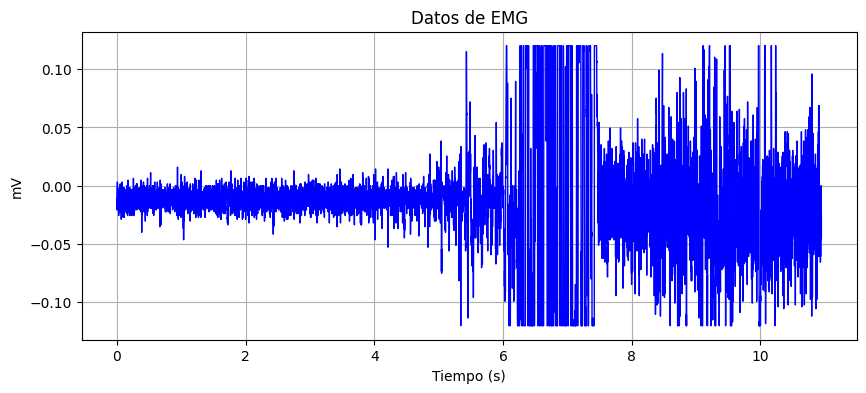

In [ ]:
VCC = 3.3
n = 10

Fs = 1000
#cargamos los datos desde el archivo txt

datos1 = L3_data[:, 16] #el 5 y 16 contienen la información
datos2 = L5_data[:, 5]
datos = (datos1+datos2)/2
print(datos)
datos = 1000*((((datos/(2**n)) - 0.5) * VCC)/1009)

# Función para aplicar el umbral
def apply_threshold(arr, upper_threshold=0.12, lower_threshold=-0.12):
    arr = np.where(arr > upper_threshold, upper_threshold, arr)
    arr = np.where(arr < lower_threshold, lower_threshold, arr)
    return arr

datos = apply_threshold(datos)


frec_muestreo = Fs #por el teorema de Nyquist
tiempo = np.arange(len(datos)) / frec_muestreo
plt.figure(figsize=(10, 4))  # Ajusta el tamaño del gráfico según tus necesidades
plt.plot(tiempo, datos, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('mV')
plt.title('Datos de EMG')
plt.grid(True)
plt.show()

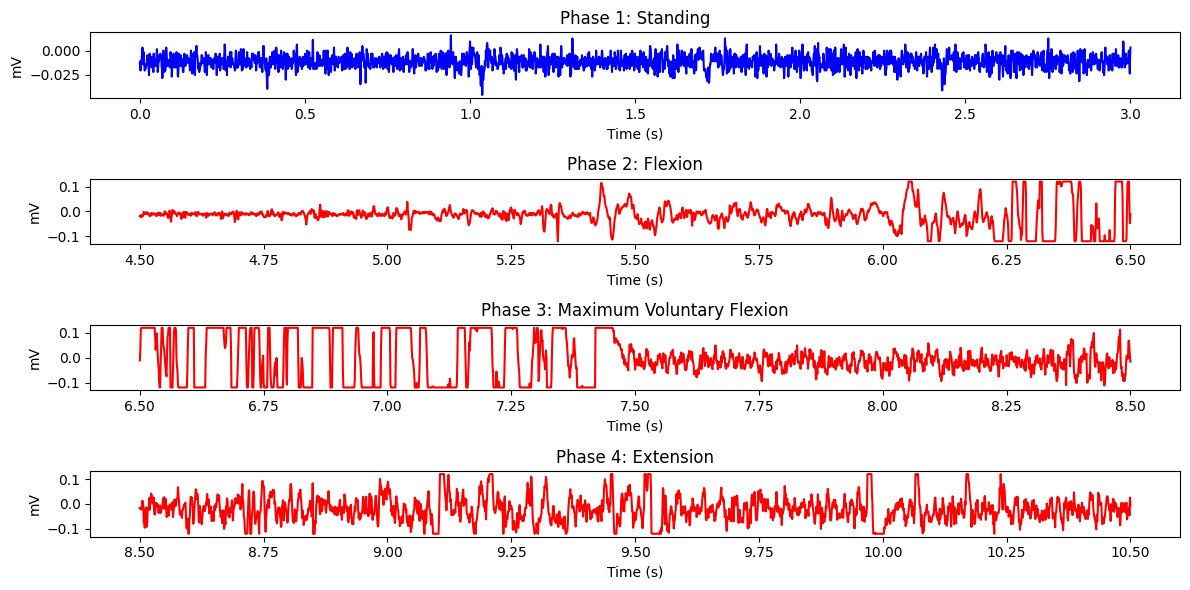

In [ ]:
segment_1 = (tiempo >= 0) & (tiempo <= 3) #standing
segment_2 = (tiempo >= 4.5) & (tiempo <= 6.5) #flexión
segment_3 = (tiempo >= 6.5) & (tiempo <= 8.5) #Máxima flexión
segment_4 = (tiempo >= 8.5) & (tiempo <= 10.5) #extensión



time_segment_1 = tiempo[segment_1]
signal_segment_1 = datos[segment_1]

time_segment_2 = tiempo[segment_2]
signal_segment_2 = datos[segment_2]

time_segment_3 = tiempo[segment_3]
signal_segment_3 = datos[segment_3]

time_segment_4 = tiempo[segment_4]
signal_segment_4 = datos[segment_4]

# Plotting the segmented signals
plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.plot(time_segment_1, signal_segment_1, color='blue')
plt.title("Phase 1: Standing")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 2)
plt.plot(time_segment_2, signal_segment_2, color='red')
plt.title("Phase 2: Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 3)
plt.plot(time_segment_3, signal_segment_3, color='red')
plt.title("Phase 3: Maximum Voluntary Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 4)
plt.plot(time_segment_4, signal_segment_4, color='red')
plt.title("Phase 4: Extension")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.tight_layout()
plt.show()


In [ ]:
raw_average_segm_phase1 = np.mean(signal_segment_1)
print(f"Raw Average SEMG Phase 1: {raw_average_segm_phase1} mV")

raw_maximum_segm_phase2 = np.max(signal_segment_2)
print(f"Raw Maximum SEMG Phase 2: {raw_maximum_segm_phase2} mV")

raw_average_segm_phase3 = np.mean(signal_segment_3)
print(f"Raw Average SEMG Phase 3: {raw_average_segm_phase3} mV")

raw_maximum_segm_phase4 = np.max(signal_segment_4)
print(f"Raw Maximum SEMG Phase 4: {raw_maximum_segm_phase4} mV")

Raw Average SEMG Phase 1: -0.011539480361724485 mV
Raw Maximum SEMG Phase 2: 0.12 mV
Raw Average SEMG Phase 3: -0.003870788953578216 mV
Raw Maximum SEMG Phase 4: 0.12 mV


In [ ]:
# Frecuencia de muestreo
sampling_rate = 1000

# Filtrado de paso banda
def bandpass_filter(signal, lowcut, highcut, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Filtro Notch
def notch_filter(signal, notch_freq, sampling_rate, quality_factor=30):
    nyquist = 0.5 * sampling_rate
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Aplicar filtros
bandpass_reposo_emg = bandpass_filter(signal_segment_1, 20, 430, sampling_rate)
bandpass_flexion_emg = bandpass_filter(signal_segment_2, 20, 430, sampling_rate)
bandpass_max_flexion_emg = bandpass_filter(signal_segment_3, 20, 430, sampling_rate)
bandpass_extension_emg = bandpass_filter(signal_segment_4, 20, 430, sampling_rate)

notch_reposo_emg = notch_filter(bandpass_reposo_emg, 60, sampling_rate)
notch_flexion_emg = notch_filter(bandpass_flexion_emg, 60, sampling_rate)
notch_max_flexion_emg = notch_filter(bandpass_max_flexion_emg, 60, sampling_rate)
notch_extension_emg = notch_filter(bandpass_extension_emg, 60, sampling_rate)

# Rectificación
rectified_reposo_emg = np.abs(notch_reposo_emg)
rectified_flexion_emg = np.abs(notch_flexion_emg)
rectified_max_flexion_emg = np.abs(notch_max_flexion_emg)
rectified_extension_emg = np.abs(notch_extension_emg)

# Suavizado con RMS
def rms_filter(signal, window_size):
    rms_signal = np.sqrt(np.convolve(signal**2, np.ones(window_size)/window_size, mode='same'))
    return rms_signal

window_size = 55 #int(0.1 * sampling_rate)  # 100 ms window
smoothed_reposo_emg = rms_filter(rectified_reposo_emg, window_size)
smoothed_flexion_emg = rms_filter(rectified_flexion_emg, window_size)
smoothed_max_flexion_emg = rms_filter(rectified_max_flexion_emg, window_size)
smoothed_extension_emg = rms_filter(rectified_extension_emg, window_size)

# Normalización
#def normalize(signal, stand):
#    return (signal) / (np.mean(stand))

# Normalización
def normalize(signal, stand):
    return (signal) / (np.mean(stand))

#normalized_reposo_emg = normalize(smoothed_reposo_emg)
normalized_flexion_emg = normalize(smoothed_flexion_emg, smoothed_reposo_emg)
normalized_max_flexion_emg = normalize(smoothed_max_flexion_emg, smoothed_reposo_emg)
normalized_extension_emg = normalize(smoothed_extension_emg, smoothed_reposo_emg)

# Placeholder para calcular FRR
def calculate_frr(max_flex_signal, mean_mvf_signal, max_ext_signal):
    frr_flex_mvf = max_flex_signal / mean_mvf_signal
    frr_ext_mvf = max_ext_signal / mean_mvf_signal
    return frr_flex_mvf, frr_ext_mvf

max_flexion_value = np.max(normalized_flexion_emg)
mean_mvf_value = np.mean(normalized_max_flexion_emg)
max_extension_value = np.max(normalized_extension_emg)

# Calcular FRR FLEX/MVF y FRR EXT/MVF
frr_flex_mvf, frr_ext_mvf = calculate_frr(max_flexion_value, mean_mvf_value, max_extension_value)

# Imprimir FRR
print(f"FRR FLEX/MVF: {frr_flex_mvf}")
print(f"FRR EXT/MVF: {frr_ext_mvf}")

print(f"Max valor de flexión: {max_flexion_value}")
print(f"Mean valor de max_flexión: {mean_mvf_value}")
print(f"Max valor de extensión: {max_extension_value}")


FRR FLEX/MVF: 1.9014006961157186
FRR EXT/MVF: 1.6247899647754804
Max valor de flexión: 13.820757151432613
Mean valor de max_flexión: 7.268724146186747
Max valor de extensión: 11.810150049445449


# Isabel

In [ ]:
L3_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/isabel3.txt')
L5_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/isabel3.txt')

[507.5 510.  510.  ... 498.5 501.5 504. ]


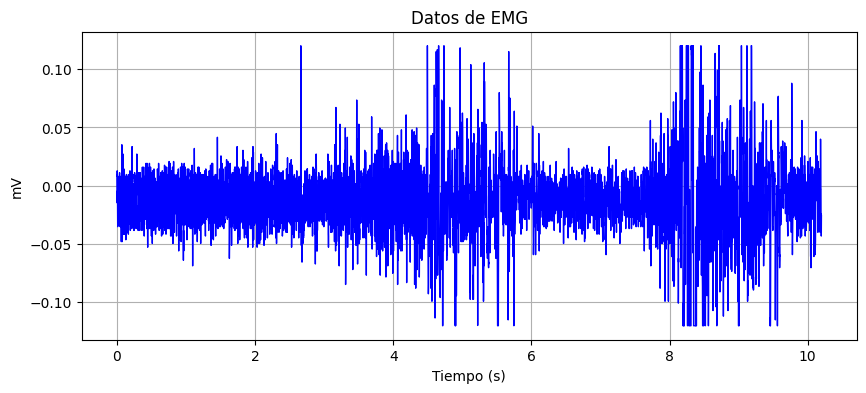

In [ ]:
VCC = 3.3
n = 10

Fs = 1000
#cargamos los datos desde el archivo txt

datos1 = L3_data[:, 16] #el 5 y 16 contienen la información
datos2 = L5_data[:, 5]
datos = (datos1+datos2)/2
print(datos)
datos = 1000*((((datos/(2**n)) - 0.5) * VCC)/1009)


# Función para aplicar el umbral
def apply_threshold(arr, upper_threshold=0.12, lower_threshold=-0.12):
    arr = np.where(arr > upper_threshold, upper_threshold, arr)
    arr = np.where(arr < lower_threshold, lower_threshold, arr)
    return arr

datos = apply_threshold(datos)


frec_muestreo = Fs #por el teorema de Nyquist
tiempo = np.arange(len(datos)) / frec_muestreo
plt.figure(figsize=(10, 4))  # Ajusta el tamaño del gráfico según tus necesidades
plt.plot(tiempo, datos, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('mV')
plt.title('Datos de EMG')
plt.grid(True)
plt.show()

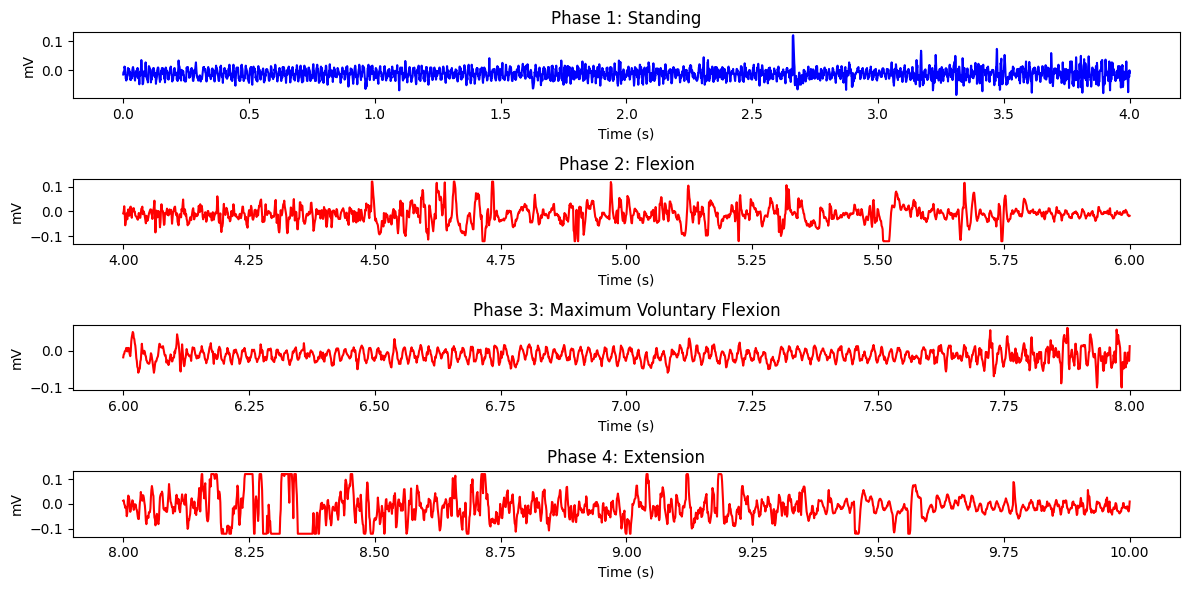

In [ ]:
segment_1 = (tiempo >= 0) & (tiempo <= 4) #standing
segment_2 = (tiempo >= 4) & (tiempo <= 6) #flexión
segment_3 = (tiempo >= 6) & (tiempo <= 8) #Máxima flexión
segment_4 = (tiempo >= 8) & (tiempo <= 10) #extensión

time_segment_1 = tiempo[segment_1]
signal_segment_1 = datos[segment_1]

time_segment_2 = tiempo[segment_2]
signal_segment_2 = datos[segment_2]

time_segment_3 = tiempo[segment_3]
signal_segment_3 = datos[segment_3]

time_segment_4 = tiempo[segment_4]
signal_segment_4 = datos[segment_4]

# Plotting the segmented signals
plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.plot(time_segment_1, signal_segment_1, color='blue')
plt.title("Phase 1: Standing")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 2)
plt.plot(time_segment_2, signal_segment_2, color='red')
plt.title("Phase 2: Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 3)
plt.plot(time_segment_3, signal_segment_3, color='red')
plt.title("Phase 3: Maximum Voluntary Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 4)
plt.plot(time_segment_4, signal_segment_4, color='red')
plt.title("Phase 4: Extension")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.tight_layout()
plt.show()


In [ ]:
raw_average_segm_phase1 = np.mean(signal_segment_1)
print(f"Raw Average SEMG Phase 1: {raw_average_segm_phase1} mV")

raw_maximum_segm_phase2 = np.max(signal_segment_2)
print(f"Raw Maximum SEMG Phase 2: {raw_maximum_segm_phase2} mV")

raw_average_segm_phase3 = np.mean(signal_segment_3)
print(f"Raw Average SEMG Phase 3: {raw_average_segm_phase3} mV")

raw_maximum_segm_phase4 = np.max(signal_segment_4)
print(f"Raw Maximum SEMG Phase 4: {raw_maximum_segm_phase4} mV")

Raw Average SEMG Phase 1: -0.012183207643641617 mV
Raw Maximum SEMG Phase 2: 0.12 mV
Raw Average SEMG Phase 3: -0.0118498728831818 mV
Raw Maximum SEMG Phase 4: 0.12 mV


FRR FLEX/MVF: 5.708976404767937
FRR EXT/MVF: 6.390259292598087
Max valor de flexión: 4.597749735179708
Mean valor de max_flexión: 0.8053544819943252
Max valor de extensión: 5.146423962399755


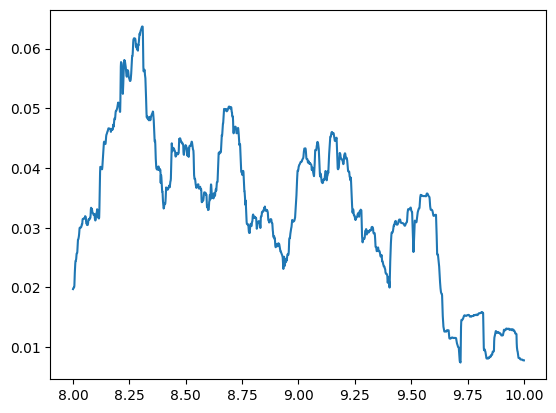

In [ ]:
# Frecuencia de muestreo
sampling_rate = 1000

# Filtrado de paso banda
def bandpass_filter(signal, lowcut, highcut, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Filtro Notch
def notch_filter(signal, notch_freq, sampling_rate, quality_factor=30):
    nyquist = 0.5 * sampling_rate
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Aplicar filtros
bandpass_reposo_emg = bandpass_filter(signal_segment_1, 20, 430, sampling_rate)
bandpass_flexion_emg = bandpass_filter(signal_segment_2, 20, 430, sampling_rate)
bandpass_max_flexion_emg = bandpass_filter(signal_segment_3, 20, 430, sampling_rate)
bandpass_extension_emg = bandpass_filter(signal_segment_4, 20, 430, sampling_rate)

notch_reposo_emg = notch_filter(bandpass_reposo_emg, 60, sampling_rate)
notch_flexion_emg = notch_filter(bandpass_flexion_emg, 60, sampling_rate)
notch_max_flexion_emg = notch_filter(bandpass_max_flexion_emg, 60, sampling_rate)
notch_extension_emg = notch_filter(bandpass_extension_emg, 60, sampling_rate)

# Rectificación
rectified_reposo_emg = np.abs(notch_reposo_emg)
rectified_flexion_emg = np.abs(notch_flexion_emg)
rectified_max_flexion_emg = np.abs(notch_max_flexion_emg)
rectified_extension_emg = np.abs(notch_extension_emg)

# Suavizado con RMS
def rms_filter(signal, window_size):
    rms_signal = np.sqrt(np.convolve(signal**2, np.ones(window_size)/window_size, mode='same'))
    return rms_signal

window_size = 100 #int(0.1 * sampling_rate)  # 100 ms window
smoothed_reposo_emg = rms_filter(rectified_reposo_emg, window_size)
smoothed_flexion_emg = rms_filter(rectified_flexion_emg, window_size)
smoothed_max_flexion_emg = rms_filter(rectified_max_flexion_emg, window_size)
smoothed_extension_emg = rms_filter(rectified_extension_emg, window_size)

# Normalización
#def normalize(signal, stand):
#    return (signal) / (np.mean(stand))

# Normalización
def normalize(signal, stand):
    return (signal) / (np.mean(stand))

#normalized_reposo_emg = normalize(smoothed_reposo_emg)
normalized_flexion_emg = normalize(smoothed_flexion_emg, smoothed_reposo_emg)
normalized_max_flexion_emg = normalize(smoothed_max_flexion_emg, smoothed_reposo_emg)
normalized_extension_emg = normalize(smoothed_extension_emg, smoothed_reposo_emg)

# Placeholder para calcular FRR
def calculate_frr(max_flex_signal, mean_mvf_signal, max_ext_signal):
    frr_flex_mvf = max_flex_signal / mean_mvf_signal
    frr_ext_mvf = max_ext_signal / mean_mvf_signal
    return frr_flex_mvf, frr_ext_mvf

max_flexion_value = np.max(normalized_flexion_emg)
mean_mvf_value = np.mean(normalized_max_flexion_emg)
max_extension_value = np.max(normalized_extension_emg)

# Calcular FRR FLEX/MVF y FRR EXT/MVF
frr_flex_mvf, frr_ext_mvf = calculate_frr(max_flexion_value, mean_mvf_value, max_extension_value)

# Imprimir FRR
print(f"FRR FLEX/MVF: {frr_flex_mvf}")
print(f"FRR EXT/MVF: {frr_ext_mvf}")

print(f"Max valor de flexión: {max_flexion_value}")
print(f"Mean valor de max_flexión: {mean_mvf_value}")
print(f"Max valor de extensión: {max_extension_value}")

plt.plot(time_segment_4, smoothed_extension_emg)

# Nicole

In [ ]:
L3_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/Nicole1.txt')
L5_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/Nicole1.txt')

[515.5 514.  513.  ... 510.5 511.  514. ]


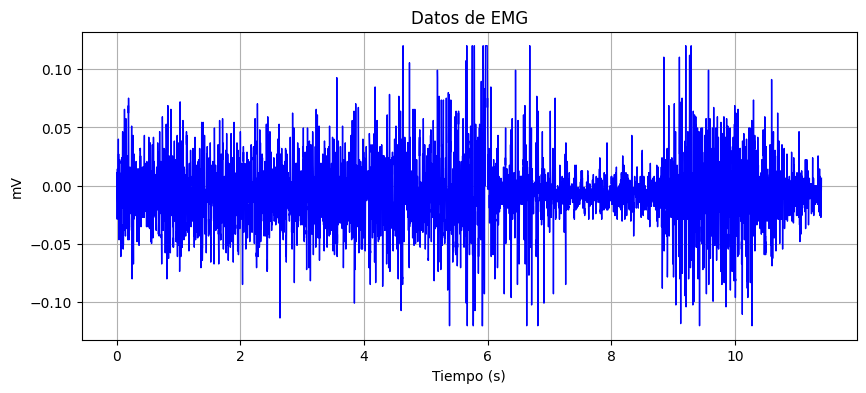

In [ ]:
VCC = 3.3
n = 10

Fs = 1000
#cargamos los datos desde el archivo txt

datos1 = L3_data[:, 16] #el 5 y 16 contienen la información
datos2 = L5_data[:, 5]
datos = (datos1+datos2)/2
print(datos)
datos = 1000*((((datos/(2**n)) - 0.5) * VCC)/1009)


# Función para aplicar el umbral
def apply_threshold(arr, upper_threshold=0.12, lower_threshold=-0.12):
    arr = np.where(arr > upper_threshold, upper_threshold, arr)
    arr = np.where(arr < lower_threshold, lower_threshold, arr)
    return arr

datos = apply_threshold(datos)


frec_muestreo = Fs #por el teorema de Nyquist
tiempo = np.arange(len(datos)) / frec_muestreo
plt.figure(figsize=(10, 4))  # Ajusta el tamaño del gráfico según tus necesidades
plt.plot(tiempo, datos, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('mV')
plt.title('Datos de EMG')
plt.grid(True)
plt.show()

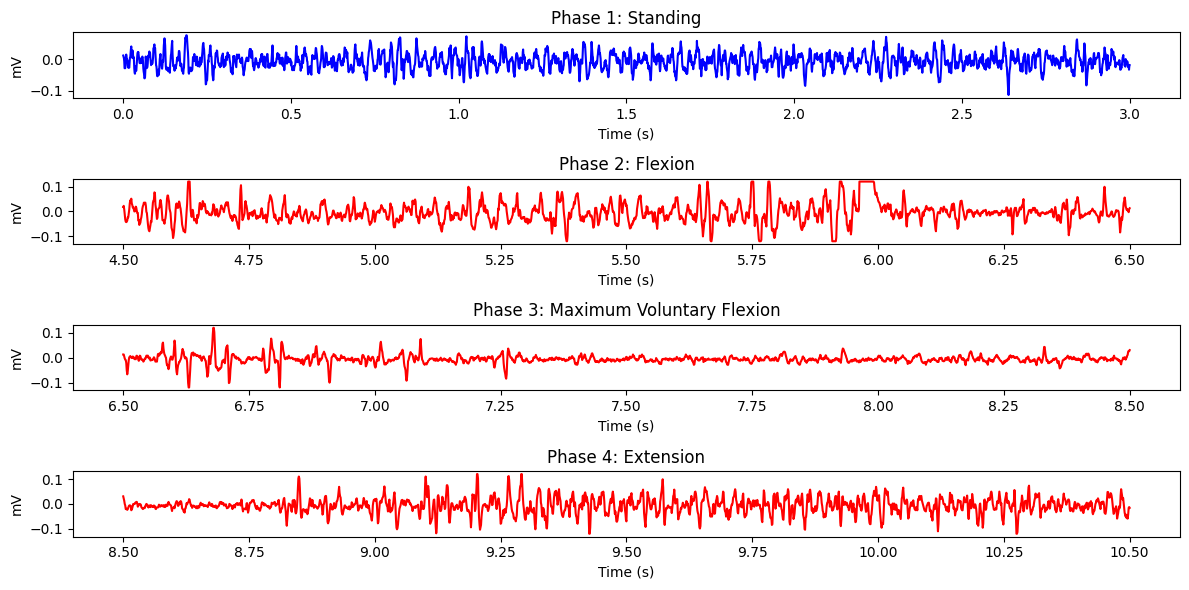

In [ ]:
segment_1 = (tiempo >= 0) & (tiempo <= 3) #standing
segment_2 = (tiempo >= 4.5) & (tiempo <= 6.5) #flexión
segment_3 = (tiempo >= 6.5) & (tiempo <= 8.5) #Máxima flexión
segment_4 = (tiempo >= 8.5) & (tiempo <= 10.5) #extensión

time_segment_1 = tiempo[segment_1]
signal_segment_1 = datos[segment_1]

time_segment_2 = tiempo[segment_2]
signal_segment_2 = datos[segment_2]

time_segment_3 = tiempo[segment_3]
signal_segment_3 = datos[segment_3]

time_segment_4 = tiempo[segment_4]
signal_segment_4 = datos[segment_4]

# Plotting the segmented signals
plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.plot(time_segment_1, signal_segment_1, color='blue')
plt.title("Phase 1: Standing")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 2)
plt.plot(time_segment_2, signal_segment_2, color='red')
plt.title("Phase 2: Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 3)
plt.plot(time_segment_3, signal_segment_3, color='red')
plt.title("Phase 3: Maximum Voluntary Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 4)
plt.plot(time_segment_4, signal_segment_4, color='red')
plt.title("Phase 4: Extension")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.tight_layout()
plt.show()

In [ ]:
raw_average_segm_phase1 = np.mean(signal_segment_1)
print(f"Raw Average SEMG Phase 1: {raw_average_segm_phase1} mV")

raw_maximum_segm_phase2 = np.max(signal_segment_2)
print(f"Raw Maximum SEMG Phase 2: {raw_maximum_segm_phase2} mV")

raw_average_segm_phase3 = np.mean(signal_segment_3)
print(f"Raw Average SEMG Phase 3: {raw_average_segm_phase3} mV")

raw_maximum_segm_phase4 = np.max(signal_segment_4)
print(f"Raw Maximum SEMG Phase 4: {raw_maximum_segm_phase4} mV")

Raw Average SEMG Phase 1: -0.006810342156760432 mV
Raw Maximum SEMG Phase 2: 0.12 mV
Raw Average SEMG Phase 3: -0.006338455330994065 mV
Raw Maximum SEMG Phase 4: 0.12 mV


In [ ]:
# Frecuencia de muestreo
sampling_rate = 1000

# Filtrado de paso banda
def bandpass_filter(signal, lowcut, highcut, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Filtro Notch
def notch_filter(signal, notch_freq, sampling_rate, quality_factor=30):
    nyquist = 0.5 * sampling_rate
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Aplicar filtros
bandpass_reposo_emg = bandpass_filter(signal_segment_1, 20, 430, sampling_rate)
bandpass_flexion_emg = bandpass_filter(signal_segment_2, 20, 430, sampling_rate)
bandpass_max_flexion_emg = bandpass_filter(signal_segment_3, 20, 430, sampling_rate)
bandpass_extension_emg = bandpass_filter(signal_segment_4, 20, 430, sampling_rate)

notch_reposo_emg = notch_filter(bandpass_reposo_emg, 60, sampling_rate)
notch_flexion_emg = notch_filter(bandpass_flexion_emg, 60, sampling_rate)
notch_max_flexion_emg = notch_filter(bandpass_max_flexion_emg, 60, sampling_rate)
notch_extension_emg = notch_filter(bandpass_extension_emg, 60, sampling_rate)

# Rectificación
rectified_reposo_emg = np.abs(notch_reposo_emg)
rectified_flexion_emg = np.abs(notch_flexion_emg)
rectified_max_flexion_emg = np.abs(notch_max_flexion_emg)
rectified_extension_emg = np.abs(notch_extension_emg)

# Suavizado con RMS
def rms_filter(signal, window_size):
    rms_signal = np.sqrt(np.convolve(signal**2, np.ones(window_size)/window_size, mode='same'))
    return rms_signal

window_size = 55 #int(0.1 * sampling_rate)  # 100 ms window
smoothed_reposo_emg = rms_filter(rectified_reposo_emg, window_size)
smoothed_flexion_emg = rms_filter(rectified_flexion_emg, window_size)
smoothed_max_flexion_emg = rms_filter(rectified_max_flexion_emg, window_size)
smoothed_extension_emg = rms_filter(rectified_extension_emg, window_size)

# Normalización
#def normalize(signal, stand):
#    return (signal) / (np.mean(stand))

# Normalización
def normalize(signal, stand):
    return (signal) / (np.mean(stand))

#normalized_reposo_emg = normalize(smoothed_reposo_emg)
normalized_flexion_emg = normalize(smoothed_flexion_emg, smoothed_reposo_emg)
normalized_max_flexion_emg = normalize(smoothed_max_flexion_emg, smoothed_reposo_emg)
normalized_extension_emg = normalize(smoothed_extension_emg, smoothed_reposo_emg)

# Placeholder para calcular FRR
def calculate_frr(max_flex_signal, mean_mvf_signal, max_ext_signal):
    frr_flex_mvf = max_flex_signal / mean_mvf_signal
    frr_ext_mvf = max_ext_signal / mean_mvf_signal
    return frr_flex_mvf, frr_ext_mvf

max_flexion_value = np.max(normalized_flexion_emg)
mean_mvf_value = np.mean(normalized_max_flexion_emg)
max_extension_value = np.max(normalized_extension_emg)

# Calcular FRR FLEX/MVF y FRR EXT/MVF
frr_flex_mvf, frr_ext_mvf = calculate_frr(max_flexion_value, mean_mvf_value, max_extension_value)

# Imprimir FRR
print(f"FRR FLEX/MVF: {frr_flex_mvf}")
print(f"FRR EXT/MVF: {frr_ext_mvf}")

print(f"Max valor de flexión: {max_flexion_value}")
print(f"Mean valor de max_flexión: {mean_mvf_value}")
print(f"Max valor de extensión: {max_extension_value}")

FRR FLEX/MVF: 5.416739880326472
FRR EXT/MVF: 3.9668721017943116
Max valor de flexión: 3.257116958478921
Mean valor de max_flexión: 0.601305772556797
Max valor de extensión: 2.3853030938034334


# Angie

In [ ]:
L3_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/Angie1.txt')
L5_data = np.loadtxt('/content/drive/My Drive/universidad/2024-1/ISB/Proyecto/Señales/Angie1.txt')

[509.  508.  511.  ... 510.5 510.5 510. ]


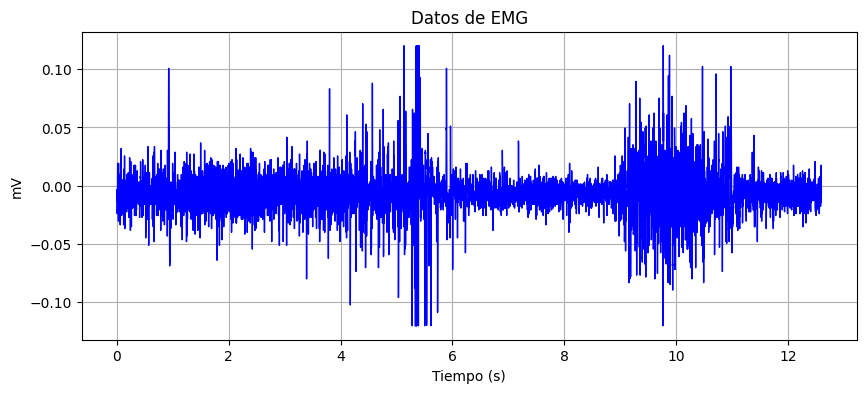

In [ ]:
VCC = 3.3
n = 10

Fs = 1000
#cargamos los datos desde el archivo txt

datos1 = L3_data[:, 16] #el 5 y 16 contienen la información
datos2 = L5_data[:, 5]
datos = (datos1+datos2)/2
print(datos)
datos = 1000*((((datos/(2**n)) - 0.5) * VCC)/1009)



# Función para aplicar el umbral
def apply_threshold(arr, upper_threshold=0.12, lower_threshold=-0.12):
    arr = np.where(arr > upper_threshold, upper_threshold, arr)
    arr = np.where(arr < lower_threshold, lower_threshold, arr)
    return arr

datos = apply_threshold(datos)


frec_muestreo = Fs #por el teorema de Nyquist
tiempo = np.arange(len(datos)) / frec_muestreo
plt.figure(figsize=(10, 4))  # Ajusta el tamaño del gráfico según tus necesidades
plt.plot(tiempo, datos, lw=1, color='blue')
plt.xlabel('Tiempo (s)')
plt.ylabel('mV')
plt.title('Datos de EMG')
plt.grid(True)
plt.show()



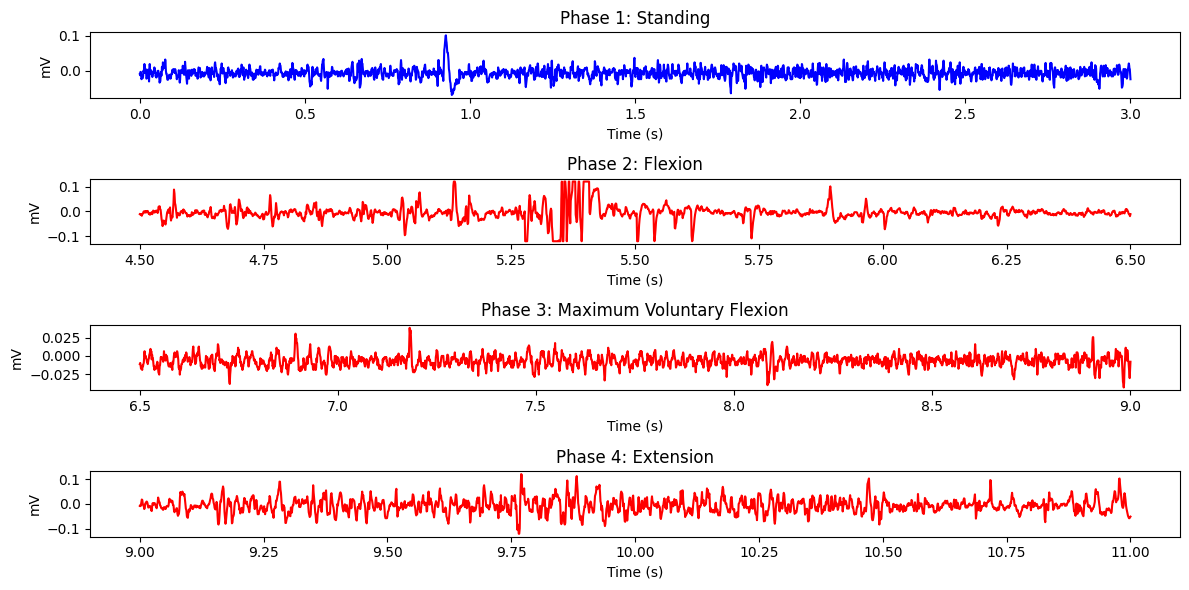

In [ ]:
segment_1 = (tiempo >= 0) & (tiempo <= 3) #standing
segment_2 = (tiempo >= 4.5) & (tiempo <= 6.5) #flexión
segment_3 = (tiempo >= 6.5) & (tiempo <= 9) #Máxima flexión
segment_4 = (tiempo >= 9) & (tiempo <= 11) #extensión

time_segment_1 = tiempo[segment_1]
signal_segment_1 = datos[segment_1]

time_segment_2 = tiempo[segment_2]
signal_segment_2 = datos[segment_2]

time_segment_3 = tiempo[segment_3]
signal_segment_3 = datos[segment_3]

time_segment_4 = tiempo[segment_4]
signal_segment_4 = datos[segment_4]

# Plotting the segmented signals
plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.plot(time_segment_1, signal_segment_1, color='blue')
plt.title("Phase 1: Standing")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 2)
plt.plot(time_segment_2, signal_segment_2, color='red')
plt.title("Phase 2: Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 3)
plt.plot(time_segment_3, signal_segment_3, color='red')
plt.title("Phase 3: Maximum Voluntary Flexion")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.subplot(4, 1, 4)
plt.plot(time_segment_4, signal_segment_4, color='red')
plt.title("Phase 4: Extension")
plt.xlabel("Time (s)")
plt.ylabel("mV")

plt.tight_layout()
plt.show()


In [ ]:
raw_average_segm_phase1 = np.mean(signal_segment_1)
print(f"Raw Average SEMG Phase 1: {raw_average_segm_phase1} mV")

raw_maximum_segm_phase2 = np.max(signal_segment_2)
print(f"Raw Maximum SEMG Phase 2: {raw_maximum_segm_phase2} mV")

raw_average_segm_phase3 = np.mean(signal_segment_3)
print(f"Raw Average SEMG Phase 3: {raw_average_segm_phase3} mV")

raw_maximum_segm_phase4 = np.max(signal_segment_4)
print(f"Raw Maximum SEMG Phase 4: {raw_maximum_segm_phase4} mV")

Raw Average SEMG Phase 1: -0.006624624903071621 mV
Raw Maximum SEMG Phase 2: 0.12 mV
Raw Average SEMG Phase 3: -0.006786901350708477 mV
Raw Maximum SEMG Phase 4: 0.12 mV


In [ ]:
# Frecuencia de muestreo
sampling_rate = 1000

# Filtrado de paso banda
def bandpass_filter(signal, lowcut, highcut, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Filtro Notch
def notch_filter(signal, notch_freq, sampling_rate, quality_factor=30):
    nyquist = 0.5 * sampling_rate
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Aplicar filtros
bandpass_reposo_emg = bandpass_filter(signal_segment_1, 20, 430, sampling_rate)
bandpass_flexion_emg = bandpass_filter(signal_segment_2, 20, 430, sampling_rate)
bandpass_max_flexion_emg = bandpass_filter(signal_segment_3, 20, 430, sampling_rate)
bandpass_extension_emg = bandpass_filter(signal_segment_4, 20, 430, sampling_rate)

notch_reposo_emg = notch_filter(bandpass_reposo_emg, 60, sampling_rate)
notch_flexion_emg = notch_filter(bandpass_flexion_emg, 60, sampling_rate)
notch_max_flexion_emg = notch_filter(bandpass_max_flexion_emg, 60, sampling_rate)
notch_extension_emg = notch_filter(bandpass_extension_emg, 60, sampling_rate)

# Rectificación
rectified_reposo_emg = np.abs(notch_reposo_emg)
rectified_flexion_emg = np.abs(notch_flexion_emg)
rectified_max_flexion_emg = np.abs(notch_max_flexion_emg)
rectified_extension_emg = np.abs(notch_extension_emg)

# Suavizado con RMS
def rms_filter(signal, window_size):
    rms_signal = np.sqrt(np.convolve(signal**2, np.ones(window_size)/window_size, mode='same'))
    return rms_signal

window_size = 55 #int(0.1 * sampling_rate)  # 100 ms window
smoothed_reposo_emg = rms_filter(rectified_reposo_emg, window_size)
smoothed_flexion_emg = rms_filter(rectified_flexion_emg, window_size)
smoothed_max_flexion_emg = rms_filter(rectified_max_flexion_emg, window_size)
smoothed_extension_emg = rms_filter(rectified_extension_emg, window_size)

# Normalización
def normalize(signal, stand):
    return (signal) / (np.mean(stand))

#normalized_reposo_emg = normalize(smoothed_reposo_emg)
normalized_flexion_emg = normalize(smoothed_flexion_emg, smoothed_reposo_emg)
normalized_max_flexion_emg = normalize(smoothed_max_flexion_emg, smoothed_reposo_emg)
normalized_extension_emg = normalize(smoothed_extension_emg, smoothed_reposo_emg)

# Placeholder para calcular FRR
def calculate_frr(max_flex_signal, mean_mvf_signal, max_ext_signal):
    frr_flex_mvf = max_flex_signal / mean_mvf_signal
    frr_ext_mvf = max_ext_signal / mean_mvf_signal
    return frr_flex_mvf, frr_ext_mvf

max_flexion_value = np.max(normalized_flexion_emg)
mean_mvf_value = np.mean(normalized_max_flexion_emg)
max_extension_value = np.max(normalized_extension_emg)

# Calcular FRR FLEX/MVF y FRR EXT/MVF
frr_flex_mvf, frr_ext_mvf = calculate_frr(max_flexion_value, mean_mvf_value, max_extension_value)

# Imprimir FRR
print(f"FRR FLEX/MVF: {frr_flex_mvf}")
print(f"FRR EXT/MVF: {frr_ext_mvf}")

print(f"Max valor de flexión: {max_flexion_value}")
print(f"Mean valor de max_flexión: {mean_mvf_value}")
print(f"Max valor de extensión: {max_extension_value}")

FRR FLEX/MVF: 11.917707279191875
FRR EXT/MVF: 7.410160775956813
Max valor de flexión: 6.458322428165418
Mean valor de max_flexión: 0.5419098050378821
Max valor de extensión: 4.015638781398118


# Análisis estadístico

In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [368]:
# Supongamos que tienes un DataFrame con las columnas 'frecuencia' y 'FRR_FLEX_MVF'
# Frecuencia: 'diario', 'interdiario', '2 veces a la semana', 'una vez por semana'
data = pd.DataFrame({
    'frecuencia': ['1 vez por semana','diario', '2 veces a la semana', '1 vez por semana', '1 vez por semana'],
    'posición': ['mala', 'mala', 'mala', 'mala', 'correcta'],
    'tiempo': [7, 5, 7, 5, 5],
    'FRR_FLEX_MVF': [1.586061281, 3.927574342, 1.901400696, 5.708976405, 5.416739880],
    'FRR_EXT_MVF': [2.613938602, 7.340268426, 1.624789965, 6.390259293, 3.966872102]
})



# Codificar las categorías
data['frecuencia_codificada'] = data['frecuencia'].map({
    'diario': 0,
    'interdiario': 1,
    '2 veces a la semana': 2,
    'una vez por semana': 3
})

# Mostrar los datos
print(data)

# Análisis descriptivo
#print(data.groupby('frecuencia').describe())

            frecuencia  posición  tiempo  FRR_FLEX_MVF  FRR_EXT_MVF  \
0     1 vez por semana      mala       7      1.586061     2.613939   
1               diario      mala       5      3.927574     7.340268   
2  2 veces a la semana      mala       7      1.901401     1.624790   
3     1 vez por semana      mala       5      5.708976     6.390259   
4     1 vez por semana  correcta       5      5.416740     3.966872   

   frecuencia_codificada  
0                    NaN  
1                    0.0  
2                    2.0  
3                    NaN  
4                    NaN  


<ipython-input-364-6cc19877e8c1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='frecuencia', y='FRR_FLEX_MVF', data=data, palette="Set2")
<ipython-input-364-6cc19877e8c1>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='frecuencia', y='FRR_EXT_MVF', data=data, palette="Set2")


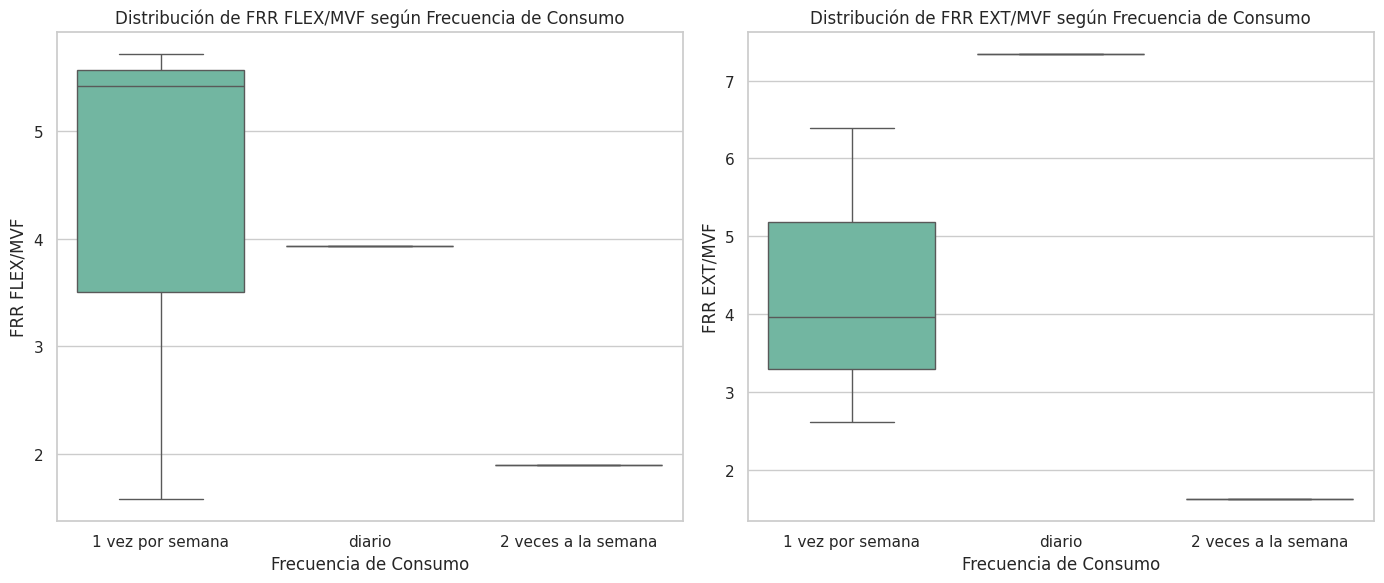

In [364]:
# Establecer el estilo de los gráficos
sns.set(style="whitegrid")

# Crear una figura con dos subgráficos
plt.figure(figsize=(14, 6))

# Gráfico de cajas para FRR_FLEX_MVF
plt.subplot(1, 2, 1)
sns.boxplot(x='frecuencia', y='FRR_FLEX_MVF', data=data, palette="Set2")
plt.xlabel('Frecuencia de Consumo')
plt.ylabel('FRR FLEX/MVF')
plt.title('Distribución de FRR FLEX/MVF según Frecuencia de Consumo')

# Gráfico de cajas para FRR_EXT_MVF
plt.subplot(1, 2, 2)
sns.boxplot(x='frecuencia', y='FRR_EXT_MVF', data=data, palette="Set2")
plt.xlabel('Frecuencia de Consumo')
plt.ylabel('FRR EXT/MVF')
plt.title('Distribución de FRR EXT/MVF según Frecuencia de Consumo')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

<ipython-input-370-c42e77ca67e7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tiempo', y='FRR_FLEX_MVF', data=data, palette="Set2")
<ipython-input-370-c42e77ca67e7>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tiempo', y='FRR_EXT_MVF', data=data, palette="Set2")


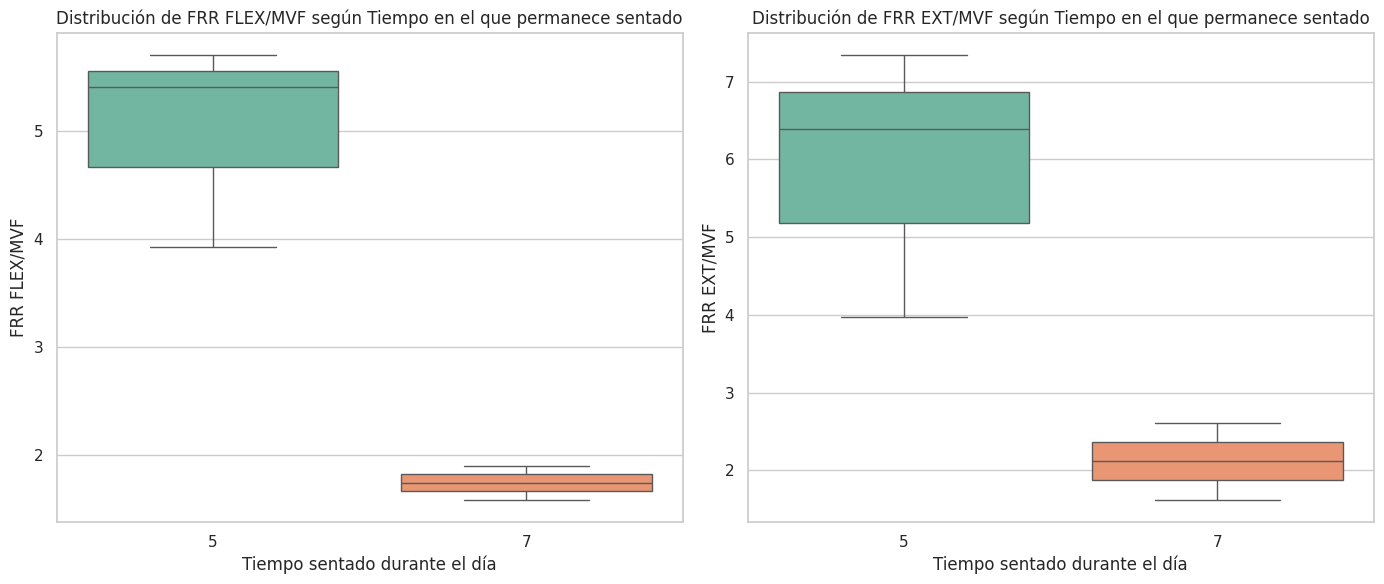

In [370]:
# Establecer el estilo de los gráficos
sns.set(style="whitegrid")

# Crear una figura con dos subgráficos
plt.figure(figsize=(14, 6))

# Gráfico de cajas para FRR_FLEX_MVF
plt.subplot(1, 2, 1)
sns.boxplot(x='tiempo', y='FRR_FLEX_MVF', data=data, palette="Set2")
plt.xlabel('Tiempo sentado durante el día')
plt.ylabel('FRR FLEX/MVF')
plt.title('Distribución de FRR FLEX/MVF según Tiempo en el que permanece sentado')

# Gráfico de cajas para FRR_EXT_MVF
plt.subplot(1, 2, 2)
sns.boxplot(x='tiempo', y='FRR_EXT_MVF', data=data, palette="Set2")
plt.xlabel('Tiempo sentado durante el día')
plt.ylabel('FRR EXT/MVF')
plt.title('Distribución de FRR EXT/MVF según Tiempo en el que permanece sentado')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

<ipython-input-371-6a15fe511571>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='posición', y='FRR_FLEX_MVF', data=data, palette="Set2")
<ipython-input-371-6a15fe511571>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='posición', y='FRR_EXT_MVF', data=data, palette="Set2")


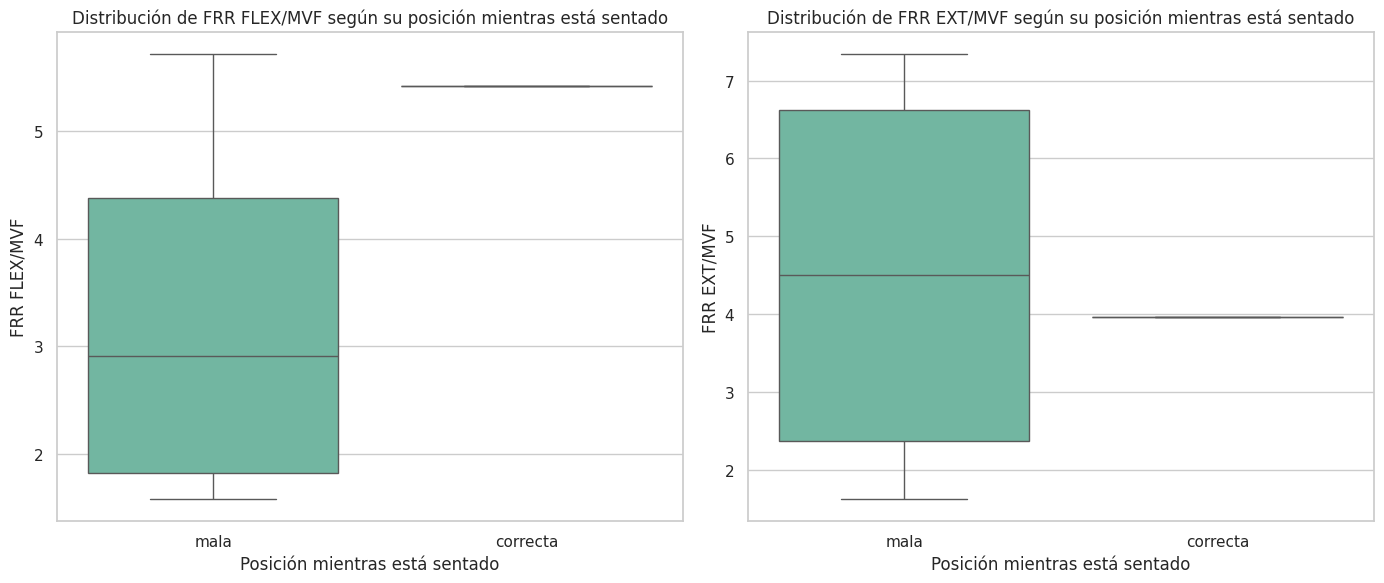

In [371]:
# Establecer el estilo de los gráficos
sns.set(style="whitegrid")

# Crear una figura con dos subgráficos
plt.figure(figsize=(14, 6))

# Gráfico de cajas para FRR_FLEX_MVF
plt.subplot(1, 2, 1)
sns.boxplot(x='posición', y='FRR_FLEX_MVF', data=data, palette="Set2")
plt.xlabel('Posición mientras está sentado')
plt.ylabel('FRR FLEX/MVF')
plt.title('Distribución de FRR FLEX/MVF según su posición mientras está sentado')

# Gráfico de cajas para FRR_EXT_MVF
plt.subplot(1, 2, 2)
sns.boxplot(x='posición', y='FRR_EXT_MVF', data=data, palette="Set2")
plt.xlabel('Posición mientras está sentado')
plt.ylabel('FRR EXT/MVF')
plt.title('Distribución de FRR EXT/MVF según su posición mientras está sentado')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [ ]:
# ANOVA
modelo = ols('FRR_FLEX_MVF ~ C(frecuencia)', data=data).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print(anova_table)

                  sum_sq   df         F    PR(>F)
C(frecuencia)   4.152360  2.0  0.392251  0.718261
Residual       10.585977  2.0       NaN       NaN


In [ ]:
# ANOVA
modelo = ols('FRR_EXT_MVF ~ C(frecuencia)', data=data).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print(anova_table)

                  sum_sq   df         F    PR(>F)
C(frecuencia)  16.363623  2.0  2.235078  0.309112
Residual        7.321277  2.0       NaN       NaN


In [372]:
# ANOVA
modelo = ols('FRR_FLEX_MVF ~ C(posición)', data=data).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print(anova_table)
# ANOVA
modelo = ols('FRR_EXT_MVF ~ C(posición)', data=data).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print(anova_table)

                sum_sq   df         F    PR(>F)
C(posición)   3.649097  1.0  0.987199  0.393666
Residual     11.089239  3.0       NaN       NaN
                sum_sq   df        F    PR(>F)
C(posición)   0.220871  1.0  0.02824  0.877237
Residual     23.464029  3.0      NaN       NaN


In [373]:
# ANOVA
modelo = ols('FRR_FLEX_MVF ~ C(tiempo)', data=data).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print(anova_table)
# ANOVA
modelo = ols('FRR_EXT_MVF ~ C(tiempo)', data=data).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print(anova_table)

              sum_sq   df          F    PR(>F)
C(tiempo)  12.863147  1.0  20.578957  0.020051
Residual    1.875189  3.0        NaN       NaN
              sum_sq   df         F    PR(>F)
C(tiempo)  17.143984  1.0  7.863112  0.067621
Residual    6.540916  3.0       NaN       NaN
